In [1]:
import pandas as pd
import os
import glob
import numpy as np
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV,RFE,chi2
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB,MultinomialNB
import warnings
from sklearn.metrics import auc,roc_curve,confusion_matrix,roc_auc_score
import matplotlib.pyplot as plt
from sklearn.utils import resample
import re
from sklearn.preprocessing import scale
warnings.filterwarnings("ignore")

In [2]:
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

In [3]:
column_name=["time","avg_rss12","var_rss12","avg_rss13","var_rss13","avg_rss23","var_rss23"]
path=os.getcwd()
te_pathes1=glob.glob(path+"/AReM/*/dataset[1-2].csv")
te_pathes2=glob.glob(path+"/AReM/*/dataset3.csv")
te_pathes2= [i for i in te_pathes2 if "bending" not in i]
te_pathes=te_pathes1+te_pathes2
te_pathes.sort()
tr_pathes=glob.glob(path+"/AReM/*/*.csv")
tr_pathes=[i for i in tr_pathes if i not in te_pathes]
tr_pathes.sort()
pathes=te_pathes+tr_pathes

In [4]:
def universal(num=1):
    list1=[]
    for i in pathes:
        df=pd.read_csv(i,sep=",",skiprows=5,header=None,names=column_name,index_col=False)
        df=df.drop("time",1)
        activity = i.split("/")[-2]
        df_new= None
        list2=[]
        for j in df.columns.tolist():
            temp=np.array_split(df[j].values,num)
            for k in temp:
                minimum=min(k)
                maximum=max(k)
                mean=np.mean(k)
                median=np.median(k)
                std=np.std(k)
                first_quartile=np.percentile(k,25)
                third_quartile=np.percentile(k,75)
                list2.extend([minimum,maximum,mean,median,std,first_quartile,third_quartile])
        list2.append(activity)
        list1.append(list2)
    col_names = []
    stats = ['min', 'max', 'mean', 'median', 'std', '1st quartile', '3rd quartile']
    for i in range(1, 6*num+1):
        for stat in stats:   
            col_names.append(stat + str(i))
    col_names.append("activity")
    df=pd.DataFrame(list1,columns=col_names)
    test=[]
    for i in np.arange(0,88):
        if i <=18:
            test.append("test")
        else:
            test.append("train")
    test=np.array(test).reshape(-1,1)
    test=pd.DataFrame(test,columns=["test"])
    df=pd.concat([df,test],axis=1)
    return df

In [5]:
def selected_feature(dataframe):
    columns=dataframe.columns.tolist()
    selected=[i for i in columns if "min" in i or "max" in i or "mean" in i or "activity" in i or "test" in i]
    selected_df= dataframe.loc[:,selected]
    return selected_df
    

# C) ii:

In [6]:
df = universal(num=1)

In [7]:
df_c_ii = df.drop(["activity","test"],1)
print(df_c_ii)

     min1   max1      mean1  median1      std1  1st quartile1  3rd quartile1  \
0   37.25  45.00  40.624792   40.500  1.475428        39.2500        42.0000   
1   38.00  45.67  42.812812   42.500  1.434054        42.0000        43.6700   
2   12.75  51.00  24.562958   24.250  3.733619        23.1875        26.5000   
3    0.00  42.75  27.464604   28.000  3.579847        25.5000        30.0000   
4   24.25  45.00  37.177042   36.250  3.577569        34.5000        40.2500   
5   28.75  44.75  37.561187   36.875  3.223144        35.2500        40.2500   
6   22.00  44.67  37.058708   36.000  3.706313        34.5000        40.0625   
7   23.50  30.00  27.716375   27.500  1.440750        27.0000        29.0000   
8   24.75  48.33  44.182937   48.000  7.487803        48.0000        48.0000   
9   48.00  48.25  48.004167   48.000  0.032005        48.0000        48.0000   
10  33.25  48.00  42.363563   43.000  2.066091        42.0000        43.5000   
11  37.00  50.75  45.917667   45.635  1.

# C) iii:

In [8]:
dictionary=dict()
for i in df_c_ii.columns:
    temp=df_c_ii[i].values
    dictionary[i]=bs.bootstrap(temp, stat_func=bs_stats.std,alpha=0.10) 

In [9]:
boot_table=pd.DataFrame(columns=["lower bound", "upper bound"])
for k,v in dictionary.items():
    temp_dict=dict()
    value= [re.sub('[\)\(]', '', i) for i in str(dictionary[k]).split()]
    temp_dict["lower bound"]=value[-2]
    temp_dict["upper bound"]=value[-1]
    temp = pd.Series(temp_dict,name=k)
    boot_table=boot_table.append(temp)

In [10]:
boot_table

,lower bound,upper bound
min1,"8.302855807925225,",10.842811654215083
max1,"3.468846956612021,",5.434731478525585
mean1,"4.773458577471971,",5.933508148766133
median1,"4.842678478999216,",6.045953143323553
std1,"1.5825629908377359,",1.9625011332213789
1st quartile1,"5.6268487264050275,",6.689780705057458
3rd quartile1,"4.415425810364777,",5.918520142853663
min2,"0.0,",0.0
max2,"4.696077243644092,",5.456718801686098
mean2,"1.431288286804175,",1.7438253485649633


# C) iv:

In [11]:
df_c_iv = selected_feature(df)
df_c_iv.head()

,min1,max1,mean1,min2,max2,mean2,min3,max3,mean3,min4,max4,mean4,min5,max5,mean5,min6,max6,mean6,activity,test
0,37.25,45.00,40.624792,0.0,1.30,0.358604,4.0,29.50,19.040937,0.0,7.23,0.832542,27.25,38.25,34.311292,0.0,1.92,0.570583,bending1,test
1,38.00,45.67,42.812812,0.0,1.22,0.372437,2.0,29.50,20.096979,0.0,5.76,0.876438,27.67,38.50,33.024583,0.0,3.11,0.571083,bending1,test
2,12.75,51.00,24.562958,0.0,6.87,0.590833,0.0,25.33,19.121333,0.0,6.76,0.736771,10.67,30.00,23.493042,0.0,4.97,0.700188,bending2,test
3,0.00,42.75,27.464604,0.0,7.76,0.449708,7.5,35.00,20.842542,0.0,5.76,0.779917,0.00,33.00,17.617938,0.0,6.76,1.122125,bending2,test
4,24.25,45.00,37.177042,0.0,8.58,2.374208,5.5,26.75,16.531083,0.0,8.05,2.910604,7.00,25.50,19.607250,0.0,9.34,2.921729,cycling,test


# D) i:

In [12]:
def binary(col):
    new_col= [1 if "bending" in i else 0 for i in col]
    return new_col

In [13]:
df_d_i=df[df["test"]=="train"].drop("test",1)
df_d_i["activity"]=binary(df_d_i["activity"])

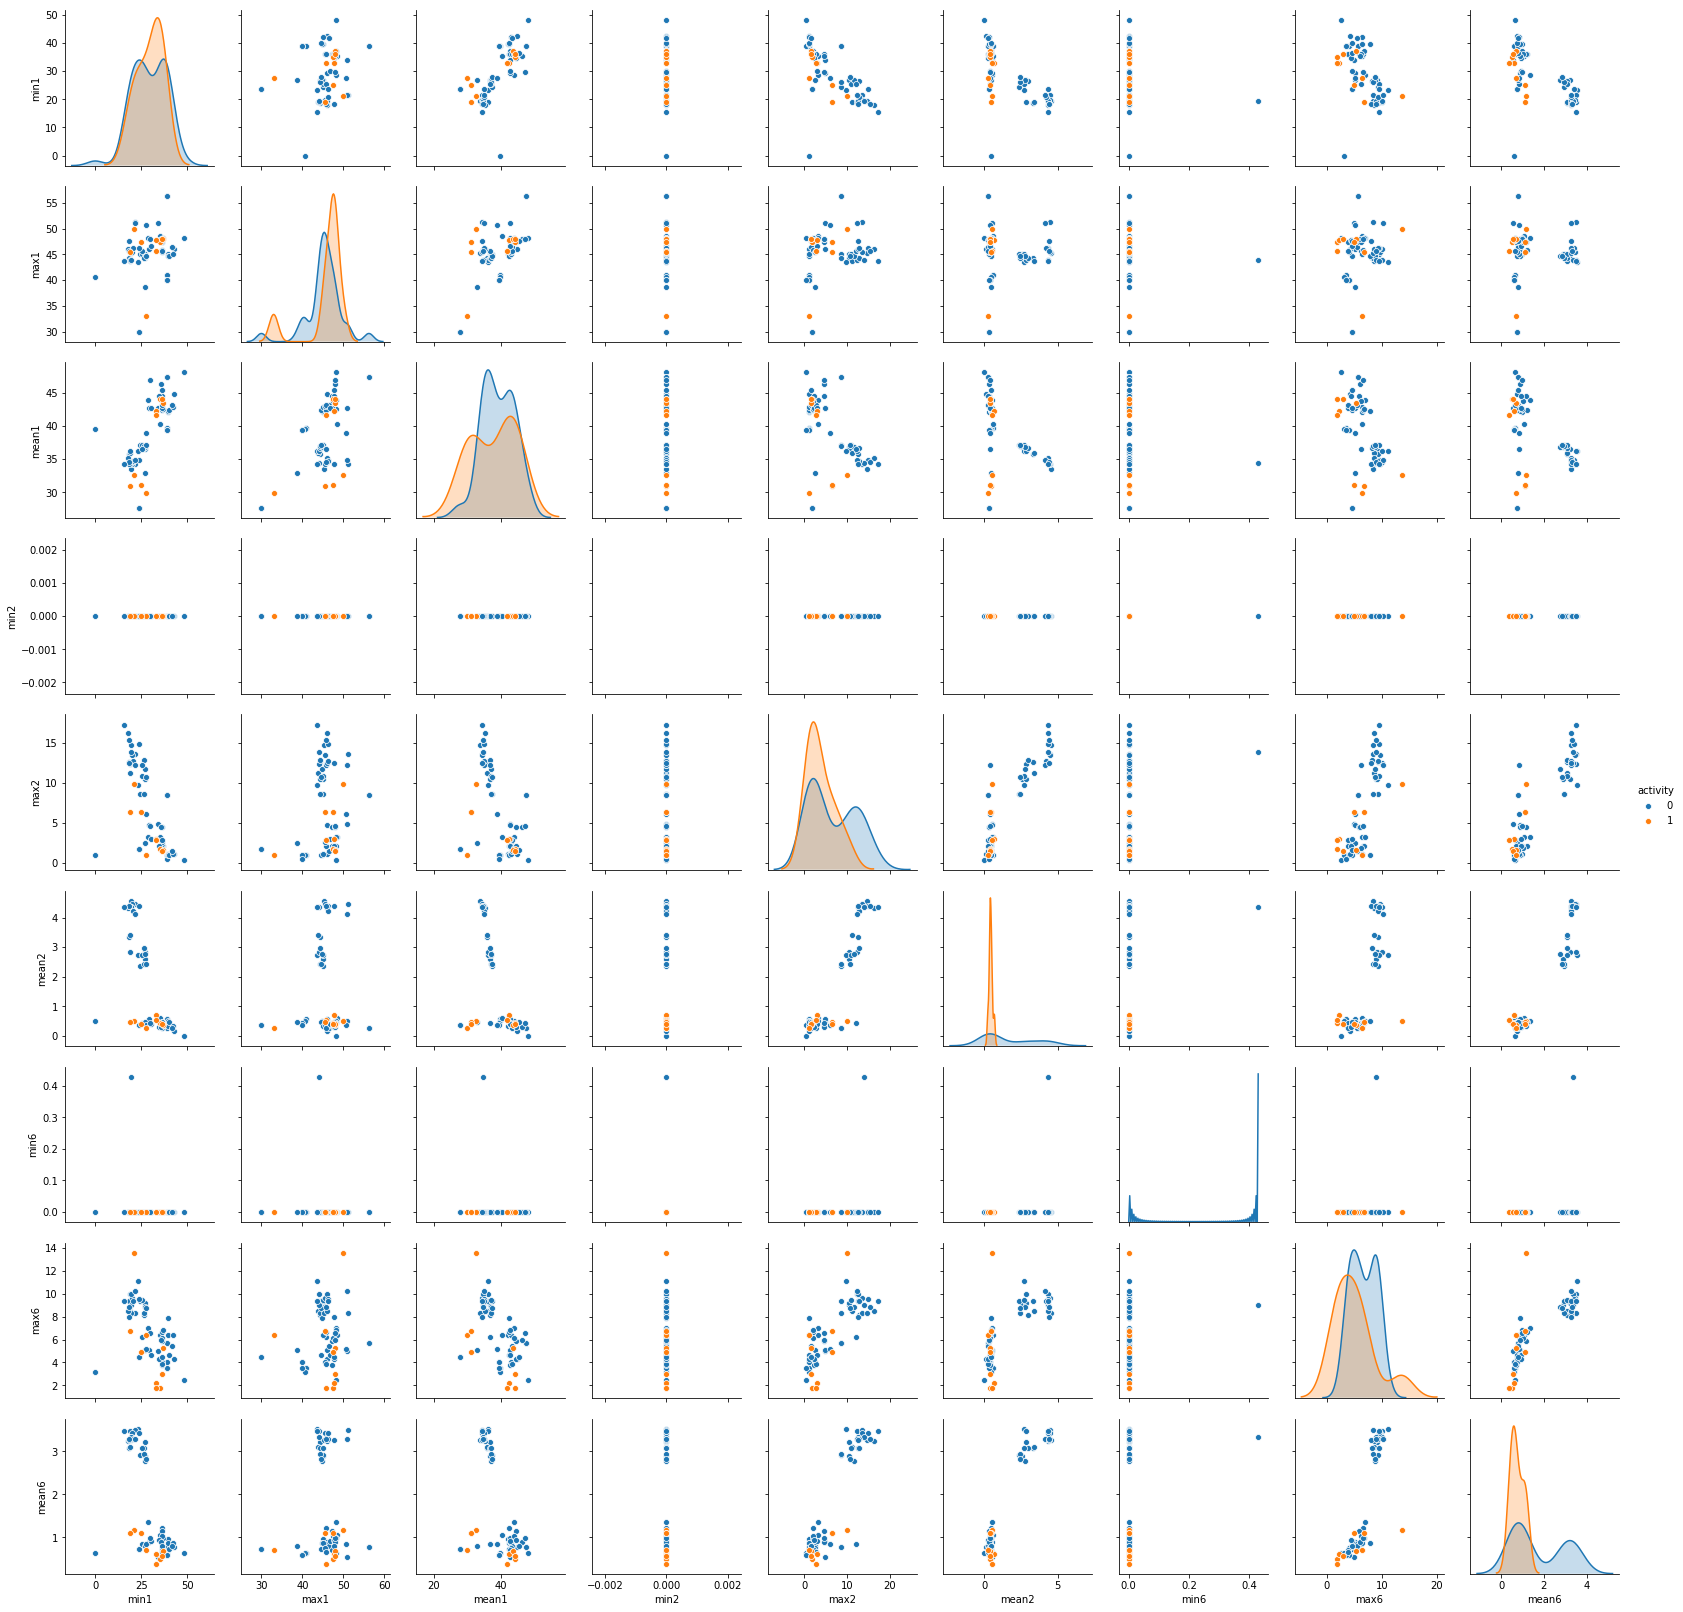

In [14]:
display(sns.pairplot(df_d_i, vars=["min1", "max1","mean1","min2","max2","mean2","min6","max6","mean6"],hue="activity"))

# D) ii:

In [15]:
df_d_ii=universal(num=2)
df_d_ii=df_d_ii[df_d_ii["test"]=="train"].drop("test",1)
df_d_ii["activity"]=binary(df_d_ii["activity"])

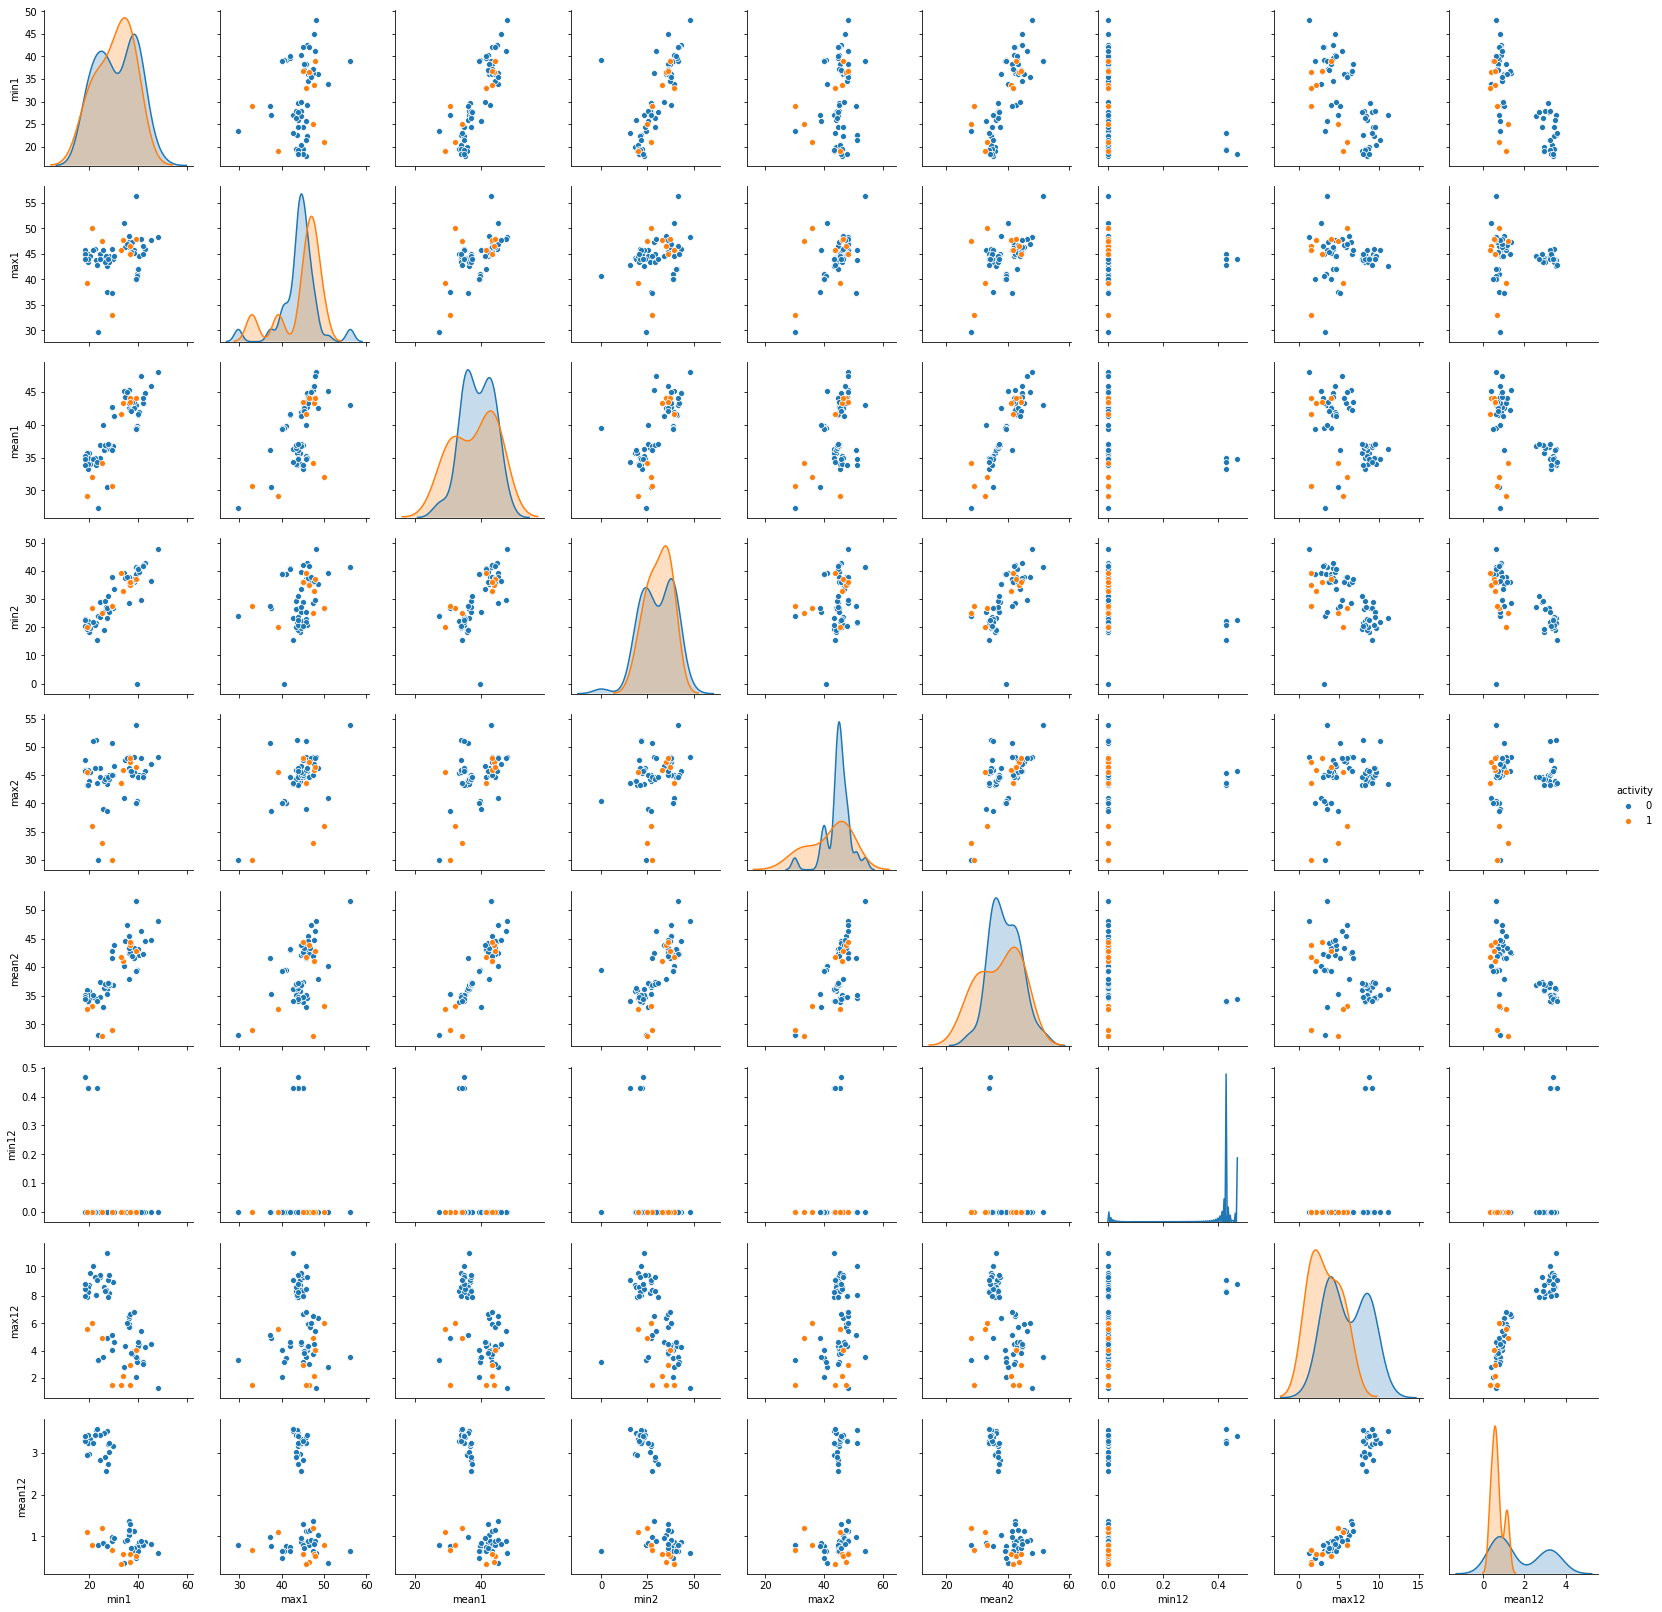

In [16]:
display(sns.pairplot(df_d_ii, vars=["min1", "max1","mean1","min2","max2","mean2","min12","max12","mean12"],hue="activity"))

# D) iii:

In [17]:
def pro_d_iii():
    acc_score=0
    optimal_pair=dict()
    opt_rfe=None
    opt_df=None
    for i in np.arange(1,21,1):
        df=universal(num=i)
        df["activity"]=binary(df["activity"])
        df1=df[df["test"]=="train"].drop("test",1)
        y_tr=df1["activity"]
        x_tr=df1.drop("activity",1)
        rfe= RFECV(estimator=LogisticRegression(),cv=5, scoring='accuracy')
        rfe=rfe.fit(x_tr,y_tr)
        rfe_acc= rfe.score(x_tr,y_tr)
        rfe_p=rfe.ranking_.tolist().count(1)
        if acc_score<rfe_acc:
            acc_score=rfe_acc
            optimal_pair["l"]=i
            optimal_pair["p"]=rfe_p
            opt_rfe= rfe
            opt_df= df
    return acc_score,optimal_pair,opt_df,opt_rfe

In [18]:
acc_d_iii,opt_pair_iii,df_d_iii,rfe_d_iii=pro_d_iii()

In [19]:
print("The optimal pair is when l is {0} and p is {1}".format(opt_pair_iii.get("l"),opt_pair_iii.get("p")))

The optimal pair is when l is 1 and p is 4


The right way to do the cross validation in this problem is to do cross validation for each model in l(from 1 to 20). Thus in each l, we could do the backward selection to find the optimal number of feature and every time we eliminate one of the features the cross validation is needed. Hence, we can use the average validated score to find the optimal number of features(p). By doing backward selection for each l, we will have 20 pairs of optimal (l,p), then we compare their validated score to decide which pair is the global optimal pair.

# D) iv:

In [20]:
x_test=df_d_iii[df_d_iii["test"]=="test"].drop("test",1)
x_train=df_d_iii[df_d_iii["test"]=="train"].drop("test",1)
y_te=x_test["activity"]
y_tr=x_train["activity"]
x_test=x_test.drop("activity",1)
x_train=x_train.drop("activity",1)
selected= x_test.columns.tolist()
selected_fea=[k for k, v in dict(list(zip(selected,rfe_d_iii.support_))).items() if v]
x_train=x_train.loc[:,selected_fea]
x_test=x_test.loc[:,selected_fea]
scores,pvalues=chi2(x_train,y_tr)
model1= LogisticRegression().fit(x_train,y_tr)

In [21]:
coef_table=pd.concat([pd.DataFrame(model1.coef_.reshape(-1,1),columns=["coef"]),pd.DataFrame(pvalues,columns=["P Vaue"])],axis=1)
coef_table.index=selected_fea

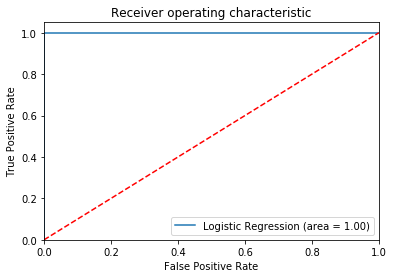

In [22]:
fpr, tpr, thresholds = roc_curve(y_tr, model1.predict_proba(x_train)[:,1])
logit_roc_auc = roc_auc_score(y_tr, model1.predict(x_train))
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [23]:
print("Confusion Matrix: \n{0} \n Coeffecient and P Value is: \n{1}\nAUC score is {2}".format(confusion_matrix(y_tr.values, model1.predict(x_train)),coef_table,logit_roc_auc))

Confusion Matrix: 
[[60  0]
 [ 0  9]] 
 Coeffecient and P Value is: 
                   coef        P Vaue
3rd quartile1 -0.649719  3.996881e-01
max2          -0.409871  1.209810e-03
min5           0.675886  2.789824e-36
max5           0.798861  3.221813e-12
AUC score is 1.0


# D) v:

In [24]:
test_acc=model1.score(x_test,y_te)
print("Test error is ",1-test_acc)

Test error is  0.0


In [25]:
if test_acc<acc_d_iii:
    print("The model performes better on training data")
elif test_acc> acc_d_iii:
    print("The model performes better on test data")
else:
    print("The model's performances on both data sets are equal")

The model's performances on both data sets are equal


# D) vi:

From the scatter plot we can see that two classes are well seperated


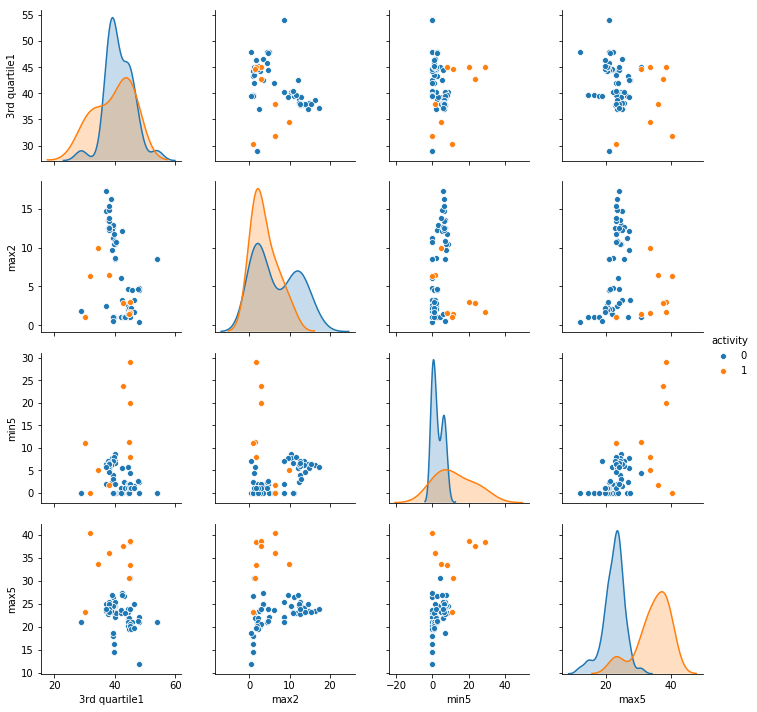

In [26]:
print(sns.pairplot(df_d_i,vars=selected_fea,hue="activity"))
print("From the scatter plot we can see that two classes are well seperated")

# D) vii:

In [27]:
def pro_d_vii():
    acc_score=0
    optimal_pair=dict()
    opt_rfe=None
    opt_df=None
    for i in np.arange(1,21,1):
        df=universal(num=i)
        df["activity"]=binary(df["activity"])
        df1=df[df["test"]=="train"].drop("test",1)
        rs_tr=df1[df1["activity"]==1]
        rs_tr= resample(rs_tr, n_samples=51)
        df1=pd.concat([df1,rs_tr],axis=0)
        y_tr_rs=df1["activity"]
        x_tr_rs=df1.drop("activity",1)
        rfe= RFECV(estimator=LogisticRegression(),cv=5, scoring='accuracy')
        rfe=rfe.fit(x_tr_rs,y_tr_rs)
        rfe_acc= rfe.score(x_tr_rs,y_tr_rs)
        rfe_p=rfe.ranking_.tolist().count(1)
        if acc_score<rfe_acc:
            acc_score=rfe_acc
            optimal_pair["l"]=i
            optimal_pair["p"]=rfe_p
            opt_rfe= rfe
            opt_df= df
            selected= x_tr_rs.columns.tolist()
            selected_fea=[k for k, v in dict(list(zip(selected,rfe.support_))).items() if v]
            x_tr_rs=x_tr_rs.loc[:,selected_fea]
            model= LogisticRegression().fit(x_tr_rs,y_tr_rs)
            fpr, tpr, thresholds = roc_curve(y_tr_rs, model.predict_proba(x_tr_rs)[:,1])
            logit_roc_auc = roc_auc_score(y_tr_rs, model.predict(x_tr_rs))
            cm=confusion_matrix(y_tr_rs.values, model.predict(x_tr_rs))
    return acc_score,optimal_pair,opt_df,opt_rfe,cm,fpr, tpr, thresholds,logit_roc_auc

In [28]:
acc_d_vii,opt_pair_vii,df_d_vii,rfe_d_vii,cm,fpr_d_vii, tpr_d_vii, thresholds_d_vii,logit_roc_auc_d_vii=pro_d_vii()

In [29]:
print("The Optimal Pair will be l = {0}, p = {1}\nConfusion Matrix is: \n {2}\nAUC Score is {3}.".format(opt_pair_vii.get("l"),opt_pair_vii.get("p"),cm,logit_roc_auc_d_vii))

The Optimal Pair will be l = 1, p = 14
Confusion Matrix is: 
 [[60  0]
 [ 0 60]]
AUC Score is 1.0.


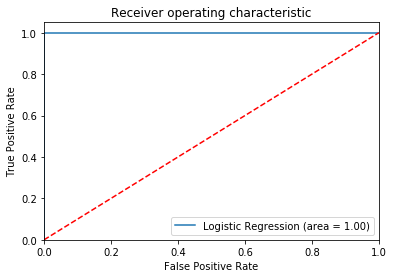

In [30]:
plt.figure()
plt.plot(fpr_d_vii, tpr_d_vii, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_d_vii)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# E) i:

In [31]:
def logistic_multi_or_bin(binar=True):
    acc_score=0
    acc_score_te=0
    optimal_pair=dict()
    for i in np.arange(1,21,1):    
        df_e_i=universal(num=i)
        df_e_i=selected_feature(df_e_i)
        if binar:
            df_e_i["activity"]=binary(df_e_i["activity"])
        df_e_i_tr=df_e_i[df_e_i["test"]=="train"].drop("test",1)
        df_e_i_te=df_e_i[df_e_i["test"]=="test"].drop("test",1)
        y_e_i_tr=df_e_i_tr["activity"]
        df_e_i_tr=scale(df_e_i_tr.drop("activity",1))
        y_e_i_te=df_e_i_te["activity"]
        df_e_i_te=scale(df_e_i_te.drop("activity",1))
        if binar:
            model= LogisticRegressionCV(penalty="l1",Cs=100,cv=5,solver="liblinear")
        else:
            model= LogisticRegressionCV(penalty="l1",Cs=100,cv=5,solver="saga",multi_class="multinomial")
        model.fit(df_e_i_tr,y_e_i_tr)
        temp_acc = model.score(df_e_i_tr,y_e_i_tr)
        temp_te_acc=model.score(df_e_i_te,y_e_i_te)
        if acc_score<temp_acc:
            acc_score=temp_acc
            optimal_pair["l"]=i
            acc_score_te=temp_te_acc
            opt_model=model
            cm=confusion_matrix(model.predict(df_e_i_te),y_e_i_te)
        return opt_model,acc_score,acc_score_te,optimal_pair,cm

In [32]:
opt_model_e_i,acc_score_e_i,acc_score_te_e_i,optimal_pair_e_i,cm_e_i=logistic_multi_or_bin(binar=True)

In [33]:
print("The Optimal Pair will be l = {0}, p = {1}, C = {2}\nTest Error is {3}".format(optimal_pair_e_i["l"],np.count_nonzero(opt_model_e_i.coef_),opt_model_e_i.C_,1-acc_score_te_e_i))


The Optimal Pair will be l = 1, p = 3, C = [0.24770764]
Test Error is 0.10526315789473684


# E) ii:

In [34]:
if test_acc<acc_score_te_e_i:
    print("L1-penalized logistic regression better")
elif test_acc> acc_score_te_e_i:
    print("variable selection using p-values better")
else:
    print("Equal")

variable selection using p-values better


    Using L1-penalized logistic regression will be easier to do the feature selection. Unlike the backward selection, the L1-penalized logistic regression does not need to run too many regression when trying to eliminate one feature from the current model. By changing the lamba we can easily find the optimal in less amount of model in each l. After finding the optimal lambda in each l, we can compare these 20 pairs and we can get the most optimal pair among all these model.

# F) i:

In [35]:
opt_model_f_i,acc_score_f_i,acc_score_te_f_i,optimal_pair_f_i,cm_f_i=logistic_multi_or_bin(binar=False)

In [36]:
print("Test error: {0}\n Optimal C is {1}.\nTest Confusion Matrix: \n{2}\nOptiaml L is {3}".format(1-acc_score_te_f_i,opt_model_f_i.C_,cm_f_i,optimal_pair_f_i.get("l")))


Test error: 0.052631578947368474
 Optimal C is [2.7825594 2.7825594 2.7825594 2.7825594 2.7825594 2.7825594 2.7825594].
Test Confusion Matrix: 
[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 1 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 0 2 0]
 [0 0 0 0 0 0 3]]
Optiaml L is 1


# F) ii:

In [37]:
def naive_baye(multino=True):
    acc=0
    opt_l=None
    opt_model=None
    for i in np.arange(1,21,1):    
        df_f=universal(num=i)
        df_f=selected_feature(df_f)
        x_tr=df_f[df_f["test"]=="train"].drop("test",1)
        x_te=df_f[df_f["test"]=="test"].drop("test",1)
        y_tr=x_tr["activity"]
        x_tr=x_tr.drop("activity",1)
        x_tr=x_tr.reset_index(drop=True)
        y_tr=y_tr.reset_index(drop=True)
        y_te=x_te["activity"]
        x_te=x_te.drop("activity",1)
        avg_acc_val=[]
        skf = StratifiedKFold(n_splits=5)
        for train_index, validate_index in skf.split(x_tr, y_tr):
            X_train =x_tr.loc[train_index]
            X_validate = x_tr.loc[validate_index]
            y_train=y_tr.loc[train_index]
            y_validate =y_tr.loc[validate_index]
            if multino:
                model = MultinomialNB()
                model.fit(X_train,y_train)
                acc_val=model.score(X_validate,y_validate)
                avg_acc_val.append(acc_val)
            else:
                model = GaussianNB()
                model.fit(X_train,y_train)
                acc_val=model.score(X_validate,y_validate)
                avg_acc_val.append(acc_val)
        avg_acc=np.mean(avg_acc_val)
        if avg_acc> acc:
            acc=avg_acc
            if multino:
                opt_model= MultinomialNB()
                opt_model.fit(x_tr,y_tr)
            else:
                opt_model= GaussianNB()
                opt_model.fit(x_tr,y_tr)
            acc_te=opt_model.score(x_te,y_te)
            te_x = x_te
            tr_x = x_tr
            te_y = y_te
            tr_y = y_tr
            opt_l= i
    return acc,opt_l,opt_model,tr_y,te_y,tr_x,te_x

# Gaussian Naive Bayes

In [38]:
acc_f1,opt_l_f1,opt_model_f1,tr_y_f1,te_y_f1,tr_x_f1,te_x_f1=naive_baye(multino=False)

In [39]:
print("Stratified Cross Validated Error is {0}\nTest error: {1}\nTest Confusion Matrix: \n{2}\nOptimal l is {3}".format(1-acc_f1,1-opt_model_f1.score(te_x_f1,te_y_f1),confusion_matrix(opt_model_f1.predict(te_x_f1),te_y_f1),opt_l_f1))


Stratified Cross Validated Error is 0.13877005347593596
Test error: 0.052631578947368474
Test Confusion Matrix: 
[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 2 0 0 0]
 [0 0 0 1 3 0 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]
Optimal l is 1


# Multinomial Naive Bayes

In [40]:
acc_f2,opt_l_f2,opt_model_f2,tr_y_f2,te_y_f2,tr_x_f2,te_x_f2=naive_baye(multino=True)

In [41]:
print("Stratified Cross Validated Error is {0}\nTest error: {1}\nTest Confusion Matrix: \n{2}\nOptimal l is {3}".format(1-acc_f2,1-opt_model_f2.score(te_x_f2,te_y_f2),confusion_matrix(opt_model_f2.predict(te_x_f2),te_y_f2),opt_l_f2))


Stratified Cross Validated Error is 0.15008912655971474
Test error: 0.26315789473684215
Test Confusion Matrix: 
[[2 1 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 1 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 2 0]
 [0 0 0 0 1 1 0]
 [0 0 0 0 0 0 3]]
Optimal l is 5


   # RuiFan Xu
   # USC ID: 1995124351

# C) ii:
         min1   max1      mean1  median1      std1  1st quartile1  3rd quartile1  \
    0   37.25  45.00  40.624792   40.500  1.475428        39.2500        42.0000   
    1   38.00  45.67  42.812812   42.500  1.434054        42.0000        43.6700   
    2   12.75  51.00  24.562958   24.250  3.733619        23.1875        26.5000   
    3    0.00  42.75  27.464604   28.000  3.579847        25.5000        30.0000   
    4   24.25  45.00  37.177042   36.250  3.577569        34.5000        40.2500   
    5   28.75  44.75  37.561187   36.875  3.223144        35.2500        40.2500   
    6   22.00  44.67  37.058708   36.000  3.706313        34.5000        40.0625   
    7   23.50  30.00  27.716375   27.500  1.440750        27.0000        29.0000   
    8   24.75  48.33  44.182937   48.000  7.487803        48.0000        48.0000   
    9   48.00  48.25  48.004167   48.000  0.032005        48.0000        48.0000   
    10  33.25  48.00  42.363563   43.000  2.066091        42.0000        43.5000   
    11  37.00  50.75  45.917667   45.635  1.087892        45.0000        46.5000   
    12  44.50  46.75  45.239667   45.000  0.429467        45.0000        45.3300   
    13  33.33  48.00  44.334729   45.000  2.474358        42.2500        46.5000   
    14  35.50  46.25  43.174938   43.670  1.986979        42.5000        44.5000   
    15  32.75  47.00  42.760562   44.500  3.395376        41.3300        45.3725   
    16  19.33  43.50  34.227771   35.500  4.884480        30.5000        37.7500   
    17  12.50  45.00  33.509729   34.125  4.845868        30.5000        36.7500   
    18  15.00  46.75  34.660583   35.000  5.309571        31.0000        38.2500   
    19  35.00  47.40  43.954500   44.330  1.557210        43.0000        45.0000   
    20  33.00  47.75  42.179812   43.500  3.666840        39.1500        45.0000   
    21  33.00  45.75  41.678063   41.750  2.241152        41.3300        42.7500   
    22  37.00  48.00  43.454958   43.250  1.384653        42.5000        45.0000   
    23  36.25  48.00  43.969125   44.500  1.616677        43.3100        44.6700   
    24  21.00  50.00  32.586208   33.000  6.231642        26.1875        34.5000   
    25  27.50  33.00  29.881938   30.000  1.152635        29.0000        30.2700   
    26  19.00  45.50  30.938104   29.000  7.676137        26.7500        38.0000   
    27  25.00  47.50  31.058250   29.710  4.824761        27.5000        31.8125   
    28  27.00  45.00  36.819521   36.000  3.896394        33.7500        40.2500   
    29  27.00  44.33  36.541667   36.000  4.014734        33.2500        39.8125   
    ..    ...    ...        ...      ...       ...            ...            ...   
    58  42.50  46.00  44.753958   45.000  0.519767        44.7500        45.0000   
    59  25.50  45.75  36.560063   36.500  5.908917        30.0000        42.5000   
    60  27.00  38.67  32.905979   30.250  3.502122        30.0000        37.0000   
    61  27.50  50.75  38.888375   36.750  3.639105        36.2500        42.0000   
    62  42.00  45.00  42.821983   42.500  0.890887        42.0000        43.5000   
    63  41.75  46.50  43.190854   42.500  1.229063        42.0000        44.5000   
    64  36.00  45.80  42.419917   42.670  2.517503        41.3300        44.6175   
    65  37.00  48.25  42.516958   42.500  2.193462        41.0000        44.5000   
    66  36.25  45.50  42.959354   42.670  1.499314        42.0000        44.3300   
    67  36.00  47.33  42.674583   43.670  2.381685        40.0000        44.7500   
    68  36.25  45.75  43.187521   44.750  2.488565        39.7500        45.0000   
    69  36.00  47.33  44.441187   45.000  2.415277        44.6275        45.7500   
    70  30.00  46.67  42.648521   42.750  2.392842        41.5000        45.0000   
    71  36.00  47.50  43.720021   45.000  2.381620        43.0000        45.0000   
    72  34.50  47.75  44.471146   45.000  1.770706        45.0000        45.2500   
    73  35.50  48.00  46.224938   46.000  1.746493        45.2500        48.0000   
    74  29.75  48.00  46.932208   47.500  1.830755        47.2375        47.7500   
    75  36.33  47.67  45.399625   45.500  1.326737        45.0000        46.3300   
    76  21.50  51.25  34.253521   35.000  4.935592        30.9375        37.7500   
    77  19.50  45.33  33.586875   34.250  4.646088        30.2500        37.0000   
    78  19.75  45.50  34.322750   35.250  4.747524        31.0000        38.0000   
    79  19.50  46.00  34.546229   35.250  4.837247        31.2500        37.8125   
    80  23.50  46.25  34.873229   35.250  4.526997        31.7500        38.2500   
    81  19.25  44.00  34.473188   35.000  4.791706        31.2500        38.0000   
    82  18.00  46.00  35.193333   36.000  4.746916        32.0000        38.7500   
    83  20.75  46.25  34.763333   35.290  4.737266        31.6700        38.2500   
    84  21.50  51.00  34.935812   35.500  4.641102        32.0000        38.0625   
    85  18.33  47.67  34.333042   34.750  4.943612        31.2500        38.0000   
    86  18.33  45.75  34.599875   35.125  4.726858        31.5000        38.0000   
    87  15.50  43.67  34.225875   34.750  4.437168        31.2500        37.2500   
    
        min2   max2     mean2      ...            std5  1st quartile5  \
    0    0.0   1.30  0.358604      ...        2.186168        33.0000   
    1    0.0   1.22  0.372437      ...        1.993175        32.0000   
    2    0.0   6.87  0.590833      ...        3.689936        20.5000   
    3    0.0   7.76  0.449708      ...        5.048375        15.0000   
    4    0.0   8.58  2.374208      ...        2.887335        17.9500   
    5    0.0   9.91  2.080687      ...        2.724534        18.0000   
    6    0.0  14.17  2.438146      ...        3.533457        16.0000   
    7    0.0   1.79  0.363687      ...        4.070265         5.5000   
    8    0.0   3.11  0.101875      ...        3.271126         2.0000   
    9    0.0   0.43  0.007167      ...        3.265096         4.6700   
    10   0.0   4.44  0.492563      ...        4.951655        10.1875   
    11   0.0   4.87  0.324542      ...        3.581774        16.5000   
    12   0.0   1.00  0.172958      ...        2.942770        17.6275   
    13   0.0   3.90  0.432958      ...        5.396165         9.3300   
    14   0.0   2.12  0.506583      ...        2.980866        12.7500   
    15   0.0   3.34  0.486167      ...        4.292096        13.0000   
    16   0.0  14.50  3.995729      ...        3.088871        14.7500   
    17   0.0  13.05  4.450771      ...        3.130299        14.6275   
    18   0.0  13.44  4.200896      ...        3.151727        14.2500   
    19   0.0   1.70  0.426250      ...        1.997520        35.3625   
    20   0.0   3.00  0.696042      ...        3.845436        30.4575   
    21   0.0   2.83  0.535979      ...        2.408514        28.4575   
    22   0.0   1.58  0.378083      ...        2.486268        22.2500   
    23   0.0   1.50  0.413125      ...        3.314843        20.5000   
    24   0.0   9.90  0.516125      ...        5.027179        17.6700   
    25   0.0   1.00  0.256437      ...        1.744151        17.0000   
    26   0.0   6.40  0.467167      ...        5.839819        15.0000   
    27   0.0   6.38  0.405458      ...        7.845242         9.0000   
    28   0.0  10.47  2.600146      ...        2.778132        15.5000   
    29   0.0  10.43  2.847958      ...        3.084922        15.0000   
    ..   ...    ...       ...      ...             ...            ...   
    58   0.0   1.12  0.153917      ...        4.123213        17.5000   
    59   0.0  12.19  0.422167      ...        2.860615        15.5000   
    60   0.0   2.49  0.456750      ...        3.732413        16.5000   
    61   0.0   6.06  0.383438      ...        4.973341        14.0000   
    62   0.0   1.12  0.335678      ...        4.107991        13.2500   
    63   0.0   1.50  0.266271      ...        3.024014        14.0000   
    64   0.0   2.12  0.460562      ...        3.718195         7.6275   
    65   0.0   2.12  0.440687      ...        3.619780        12.6275   
    66   0.0   2.60  0.352875      ...        2.699788        14.0000   
    67   0.0   2.17  0.419167      ...        3.258218        12.7500   
    68   0.0   2.83  0.271271      ...        3.562322        16.5000   
    69   0.0   4.50  0.346604      ...        3.410896        11.0000   
    70   0.0   2.95  0.402833      ...        3.138405        10.6275   
    71   0.0   1.92  0.366708      ...        3.285710        11.3100   
    72   0.0   2.18  0.290479      ...        2.609667        12.0000   
    73   0.0   4.50  0.312354      ...        2.928525        12.0000   
    74   0.0   4.60  0.429667      ...        3.131555        11.6700   
    75   0.0   1.66  0.460146      ...        3.370579        11.2500   
    76   0.0  13.55  4.457896      ...        3.113379        13.7500   
    77   0.0  14.67  4.576562      ...        3.280561        13.7300   
    78   0.0  13.47  4.456333      ...        3.116605        13.5000   
    79   0.0  12.47  4.371958      ...        2.820182        14.0000   
    80   0.0  14.82  4.380583      ...        3.127813        13.7500   
    81   0.0  13.86  4.359312      ...        3.153030        13.7300   
    82   0.0  16.20  4.321021      ...        3.204299        14.2500   
    83   0.0  12.68  4.223792      ...        3.171372        14.2500   
    84   0.0  12.21  4.115750      ...        3.188731        14.2375   
    85   0.0  12.48  4.396958      ...        2.997366        13.7500   
    86   0.0  15.37  4.398833      ...        2.902659        14.0000   
    87   0.0  17.24  4.354500      ...        2.989801        14.3300   
    
        3rd quartile5  min6   max6     mean6  median6      std6  1st quartile6  \
    0         36.0000  0.00   1.92  0.570583    0.430  0.582308         0.0000   
    1         34.5000  0.00   3.11  0.571083    0.430  0.600383         0.0000   
    2         27.0000  0.00   4.97  0.700188    0.500  0.692997         0.4300   
    3         20.7500  0.00   6.76  1.122125    0.830  1.011287         0.4700   
    4         21.7500  0.00   9.34  2.921729    2.500  1.850669         1.5000   
    5         21.5000  0.00   9.62  2.765896    2.450  1.767359         1.4100   
    6         21.0000  0.00   8.55  2.983750    2.570  1.813837         1.5000   
    7         10.7500  0.00   4.50  0.734271    0.710  0.613049         0.4300   
    8          5.5425  0.00   3.91  0.692771    0.500  0.675076         0.3225   
    9         10.0000  0.00   2.50  0.641229    0.500  0.387967         0.4600   
    10        17.6900  0.00   6.02  1.034021    0.830  0.984600         0.4700   
    11        21.0000  0.00   7.22  0.904604    0.710  0.895237         0.4300   
    12        21.0000  0.00   8.20  0.837250    0.710  0.834474         0.4300   
    13        17.7500  0.00   5.02  0.933000    0.830  0.672907         0.4700   
    14        16.5000  0.00   5.72  0.911979    0.830  0.665467         0.4700   
    15        18.5650  0.00   5.73  0.842271    0.710  0.721413         0.4300   
    16        18.6700  0.00   9.74  3.394125    3.100  1.790222         2.1050   
    17        18.7500  0.00   8.96  3.378479    3.085  1.785497         2.0600   
    18        18.5000  0.00   8.99  3.244396    3.000  1.629283         2.1200   
    19        36.5000  0.00   1.79  0.493292    0.430  0.512971         0.0000   
    20        36.3300  0.00   2.18  0.613521    0.500  0.523771         0.0000   
    21        31.2500  0.00   1.79  0.383292    0.430  0.388759         0.0000   
    22        24.0000  0.00   5.26  0.679646    0.500  0.621885         0.4300   
    23        23.7500  0.00   2.96  0.555312    0.490  0.487318         0.0000   
    24        23.5000  0.00  13.61  1.162042    0.830  1.331591         0.4700   
    25        19.0000  0.00   6.40  0.701625    0.710  0.480601         0.4700   
    26        20.8125  0.00   6.73  1.107354    0.830  1.079715         0.4700   
    27        18.3125  0.00   4.92  1.098104    0.940  0.830614         0.5000   
    28        19.2700  0.00   8.99  2.887563    2.525  1.721298         1.5600   
    29        19.5000  0.00   9.18  3.225458    2.870  1.767913         1.8850   
    ..            ...   ...    ...       ...      ...       ...            ...   
    58        21.6900  0.00   4.30  0.764083    0.700  0.651411         0.4300   
    59        19.0000  0.00   6.26  0.854833    0.830  0.716855         0.4300   
    60        20.7500  0.00   5.12  0.791354    0.710  0.754951         0.4300   
    61        20.7500  0.00   5.17  0.840208    0.820  0.749854         0.4300   
    62        19.0000  0.00   6.36  0.856013    0.820  0.764002         0.4300   
    63        18.3300  0.00   5.45  0.806229    0.820  0.644803         0.4300   
    64        12.0000  0.00   6.65  1.226271    1.090  0.891058         0.5000   
    65        17.5000  0.00   6.85  0.977417    0.830  0.852390         0.4700   
    66        16.6900  0.00   4.00  0.748479    0.820  0.460671         0.4300   
    67        16.5000  0.00   3.77  0.702042    0.500  0.566859         0.4300   
    68        21.0000  0.00   3.83  0.645458    0.500  0.566828         0.4300   
    69        14.6700  0.00   5.91  1.155083    0.940  0.841210         0.5000   
    70        14.2500  0.00   4.64  0.917354    0.830  0.708898         0.4700   
    71        15.5425  0.00   6.18  1.039687    0.830  0.915702         0.4700   
    72        14.8125  0.00   4.32  0.927375    0.830  0.755647         0.4700   
    73        15.2500  0.00   6.00  0.882583    0.830  0.667727         0.4700   
    74        15.5000  0.00   6.58  0.991125    0.830  0.854438         0.4700   
    75        14.5000  0.00   4.50  0.795104    0.820  0.502483         0.4700   
    76        18.0000  0.00   8.32  3.500750    3.285  1.690614         2.1800   
    77        18.2500  0.00   8.32  3.259729    3.110  1.638534         2.0500   
    78        17.7500  0.00   9.67  3.432563    3.200  1.730921         2.1575   
    79        17.7500  0.00  10.00  3.338125    3.080  1.655016         2.1600   
    80        18.0000  0.00   9.51  3.424646    3.270  1.689198         2.1700   
    81        17.7500  0.43   9.00  3.340458    3.090  1.697343         2.1200   
    82        18.5000  0.00   8.50  3.241958    3.015  1.767339         1.8850   
    83        18.3300  0.00   9.39  3.288271    3.270  1.645811         2.0500   
    84        18.2500  0.00  10.21  3.280021    3.015  1.699145         2.1200   
    85        18.0000  0.00   8.01  3.261583    2.980  1.615604         2.0500   
    86        18.2500  0.00   8.86  3.289542    3.015  1.678418         2.1200   
    87        18.2500  0.00   9.42  3.479542    3.270  1.759311         2.2400   
    
        3rd quartile6  
    0          1.3000  
    1          1.3000  
    2          0.8700  
    3          1.3000  
    4          3.9000  
    5          3.7700  
    6          4.1500  
    7          1.0000  
    8          0.9400  
    9          0.8300  
    10         1.2500  
    11         1.1200  
    12         1.1200  
    13         1.2500  
    14         1.2200  
    15         1.0900  
    16         4.4250  
    17         4.4400  
    18         4.2400  
    19         0.9400  
    20         1.0000  
    21         0.5000  
    22         0.8700  
    23         0.8300  
    24         1.3000  
    25         0.9400  
    26         1.3000  
    27         1.3000  
    28         3.7700  
    29         4.2625  
    ..            ...  
    58         1.0000  
    59         1.1450  
    60         1.0000  
    61         1.0900  
    62         1.0900  
    63         1.0900  
    64         1.5850  
    65         1.2200  
    66         0.9500  
    67         0.9400  
    68         0.8300  
    69         1.5000  
    70         1.1200  
    71         1.2200  
    72         1.2200  
    73         1.1200  
    74         1.2200  
    75         1.0000  
    76         4.5575  
    77         4.3225  
    78         4.5650  
    79         4.3350  
    80         4.5000  
    81         4.3750  
    82         4.4400  
    83         4.3050  
    84         4.5000  
    85         4.3200  
    86         4.2600  
    87         4.5375  
    
    [88 rows x 42 columns]


# C) iii:

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>lower bound</th>
      <th>upper bound</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>min1</th>
      <td>8.317691983902334,</td>
      <td>10.816222593716088</td>
    </tr>
    <tr>
      <th>max1</th>
      <td>3.47715886341114,</td>
      <td>5.4377743367834235</td>
    </tr>
    <tr>
      <th>mean1</th>
      <td>4.749642608540103,</td>
      <td>5.935298412315245</td>
    </tr>
    <tr>
      <th>median1</th>
      <td>4.862393692318952,</td>
      <td>6.05148317566151</td>
    </tr>
    <tr>
      <th>std1</th>
      <td>1.5851822935511803,</td>
      <td>1.957882718269732</td>
    </tr>
    <tr>
      <th>1st quartile1</th>
      <td>5.643117362052774,</td>
      <td>6.692825377790314</td>
    </tr>
    <tr>
      <th>3rd quartile1</th>
      <td>4.396037189225055,</td>
      <td>5.922281935524347</td>
    </tr>
    <tr>
      <th>min2</th>
      <td>0.0,</td>
      <td>0.0</td>
    </tr>
    <tr>
      <th>max2</th>
      <td>4.699171444883413,</td>
      <td>5.460740578888387</td>
    </tr>
    <tr>
      <th>mean2</th>
      <td>1.4367204946135244,</td>
      <td>1.74220270711794</td>
    </tr>
    <tr>
      <th>median2</th>
      <td>1.2751944537708977,</td>
      <td>1.5769768834035403</td>
    </tr>
    <tr>
      <th>std2</th>
      <td>0.8215078509196571,</td>
      <td>0.9600684979509467</td>
    </tr>
    <tr>
      <th>1st quartile2</th>
      <td>0.8514641341791203,</td>
      <td>1.0552317600940433</td>
    </tr>
    <tr>
      <th>3rd quartile2</th>
      <td>1.9456432569294906,</td>
      <td>2.344562130326663</td>
    </tr>
    <tr>
      <th>min3</th>
      <td>2.7854592344485813,</td>
      <td>3.13481777362133</td>
    </tr>
    <tr>
      <th>max3</th>
      <td>4.245580612777394,</td>
      <td>5.5460419432833294</td>
    </tr>
    <tr>
      <th>mean3</th>
      <td>3.5003142092991117,</td>
      <td>4.577203585278554</td>
    </tr>
    <tr>
      <th>median3</th>
      <td>3.5192727598882803,</td>
      <td>4.616352857987163</td>
    </tr>
    <tr>
      <th>std3</th>
      <td>0.7685300752010453,</td>
      <td>1.1237577158472107</td>
    </tr>
    <tr>
      <th>1st quartile3</th>
      <td>3.7113972007481344,</td>
      <td>4.7902901271203</td>
    </tr>
    <tr>
      <th>3rd quartile3</th>
      <td>3.6262695162701437,</td>
      <td>4.768576495292392</td>
    </tr>
    <tr>
      <th>min4</th>
      <td>0.0,</td>
      <td>0.0</td>
    </tr>
    <tr>
      <th>max4</th>
      <td>1.9937248372317447,</td>
      <td>2.3754396867830443</td>
    </tr>
    <tr>
      <th>mean4</th>
      <td>1.104349853377244,</td>
      <td>1.2522633907409673</td>
    </tr>
    <tr>
      <th>median4</th>
      <td>1.083283083710536,</td>
      <td>1.2290496514209441</td>
    </tr>
    <tr>
      <th>std4</th>
      <td>0.4283251519562863,</td>
      <td>0.49179934636186695</td>
    </tr>
    <tr>
      <th>1st quartile4</th>
      <td>0.7916297438352055,</td>
      <td>0.9072309890075783</td>
    </tr>
    <tr>
      <th>3rd quartile4</th>
      <td>1.4684546916521541,</td>
      <td>1.6621763304697794</td>
    </tr>
    <tr>
      <th>min5</th>
      <td>4.713309172812078,</td>
      <td>7.756700514106536</td>
    </tr>
    <tr>
      <th>max5</th>
      <td>4.8754590631052155,</td>
      <td>6.6780847992413905</td>
    </tr>
    <tr>
      <th>mean5</th>
      <td>4.598755941848171,</td>
      <td>6.894503112659402</td>
    </tr>
    <tr>
      <th>median5</th>
      <td>4.680706284789555,</td>
      <td>7.086834983652723</td>
    </tr>
    <tr>
      <th>std5</th>
      <td>0.8286447398708006,</td>
      <td>1.2246171165591333</td>
    </tr>
    <tr>
      <th>1st quartile5</th>
      <td>4.9399945969508385,</td>
      <td>7.35877475913768</td>
    </tr>
    <tr>
      <th>3rd quartile5</th>
      <td>4.5214041811951455,</td>
      <td>6.683837878939085</td>
    </tr>
    <tr>
      <th>min6</th>
      <td>0.013124961748951336,</td>
      <td>0.09115393165518615</td>
    </tr>
    <tr>
      <th>max6</th>
      <td>2.2688634813176556,</td>
      <td>2.7747707358123184</td>
    </tr>
    <tr>
      <th>mean6</th>
      <td>1.0878155308941464,</td>
      <td>1.2408577190045142</td>
    </tr>
    <tr>
      <th>median6</th>
      <td>1.017333897902628,</td>
      <td>1.1717910988688347</td>
    </tr>
    <tr>
      <th>std6</th>
      <td>0.4862428157392381,</td>
      <td>0.5524458963265665</td>
    </tr>
    <tr>
      <th>1st quartile6</th>
      <td>0.7051836351051876,</td>
      <td>0.8235608706136888</td>
    </tr>
    <tr>
      <th>3rd quartile6</th>
      <td>1.4370997414720788,</td>
      <td>1.6348963316865854</td>
    </tr>
  </tbody>
</table>
</div>



# C) iv:

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>min1</th>
      <th>max1</th>
      <th>mean1</th>
      <th>min2</th>
      <th>max2</th>
      <th>mean2</th>
      <th>min3</th>
      <th>max3</th>
      <th>mean3</th>
      <th>min4</th>
      <th>max4</th>
      <th>mean4</th>
      <th>min5</th>
      <th>max5</th>
      <th>mean5</th>
      <th>min6</th>
      <th>max6</th>
      <th>mean6</th>
      <th>activity</th>
      <th>test</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>37.25</td>
      <td>45.00</td>
      <td>40.624792</td>
      <td>0.0</td>
      <td>1.30</td>
      <td>0.358604</td>
      <td>4.0</td>
      <td>29.50</td>
      <td>19.040937</td>
      <td>0.0</td>
      <td>7.23</td>
      <td>0.832542</td>
      <td>27.25</td>
      <td>38.25</td>
      <td>34.311292</td>
      <td>0.0</td>
      <td>1.92</td>
      <td>0.570583</td>
      <td>bending1</td>
      <td>test</td>
    </tr>
    <tr>
      <th>1</th>
      <td>38.00</td>
      <td>45.67</td>
      <td>42.812812</td>
      <td>0.0</td>
      <td>1.22</td>
      <td>0.372437</td>
      <td>2.0</td>
      <td>29.50</td>
      <td>20.096979</td>
      <td>0.0</td>
      <td>5.76</td>
      <td>0.876438</td>
      <td>27.67</td>
      <td>38.50</td>
      <td>33.024583</td>
      <td>0.0</td>
      <td>3.11</td>
      <td>0.571083</td>
      <td>bending1</td>
      <td>test</td>
    </tr>
    <tr>
      <th>2</th>
      <td>12.75</td>
      <td>51.00</td>
      <td>24.562958</td>
      <td>0.0</td>
      <td>6.87</td>
      <td>0.590833</td>
      <td>0.0</td>
      <td>25.33</td>
      <td>19.121333</td>
      <td>0.0</td>
      <td>6.76</td>
      <td>0.736771</td>
      <td>10.67</td>
      <td>30.00</td>
      <td>23.493042</td>
      <td>0.0</td>
      <td>4.97</td>
      <td>0.700188</td>
      <td>bending2</td>
      <td>test</td>
    </tr>
    <tr>
      <th>3</th>
      <td>0.00</td>
      <td>42.75</td>
      <td>27.464604</td>
      <td>0.0</td>
      <td>7.76</td>
      <td>0.449708</td>
      <td>7.5</td>
      <td>35.00</td>
      <td>20.842542</td>
      <td>0.0</td>
      <td>5.76</td>
      <td>0.779917</td>
      <td>0.00</td>
      <td>33.00</td>
      <td>17.617938</td>
      <td>0.0</td>
      <td>6.76</td>
      <td>1.122125</td>
      <td>bending2</td>
      <td>test</td>
    </tr>
    <tr>
      <th>4</th>
      <td>24.25</td>
      <td>45.00</td>
      <td>37.177042</td>
      <td>0.0</td>
      <td>8.58</td>
      <td>2.374208</td>
      <td>5.5</td>
      <td>26.75</td>
      <td>16.531083</td>
      <td>0.0</td>
      <td>8.05</td>
      <td>2.910604</td>
      <td>7.00</td>
      <td>25.50</td>
      <td>19.607250</td>
      <td>0.0</td>
      <td>9.34</td>
      <td>2.921729</td>
      <td>cycling</td>
      <td>test</td>
    </tr>
  </tbody>
</table>
</div>



# D) i:

![png](output_17_1.png)


# D) ii:


![png](output_20_1.png)


# D) iii:


    The optimal pair is when l is 1 and p is 4


    The right way to do the cross validation in this problem is to do cross validation for each model in l(from 1 to 20). Thus in each l, we could do the backward selection to find the optimal number of feature and every time we eliminate one of the features the cross validation is needed. Hence, we can use the average validated score to find the optimal number of features(p). By doing backward selection for each l, we will have 20 pairs of optimal (l,p), then we compare their validated score to decide which pair is the global optimal pair.

# D) iv:

![png](output_29_0.png)


    Confusion Matrix: 
    [[60  0]
     [ 0  9]] 
     Coeffecient and P Value is: 
                       coef        P Vaue
    3rd quartile1 -0.649719  3.996881e-01
    max2          -0.409871  1.209810e-03
    min5           0.675886  2.789824e-36
    max5           0.798861  3.221813e-12
    AUC score is 1.0


# D) v:
    Test Error is 0.0

    The model's performances on both data sets are equal


# D) vi:

    From the scatter plot we can see that two classes are well seperated

![png](output_35_1.png)


# D) vii:

    The Optimal Pair will be l = 1, p = 14
    Confusion Matrix is: 
     [[60  0]
     [ 0 60]]
    AUC Score is 1.0.


![png](output_40_0.png)


# E) i:


    The Optimal Pair will be l = 1, p = 3, C = [0.24770764]
    Test Error is 0.10526315789473684


# E) ii:

    Model of variable selection using p-values performs better.

    Using L1-penalized logistic regression will be easier to do the feature selection. Unlike the backward selection, the L1-penalized logistic regression does not need to run too many regression when trying to eliminate one feature from the current model. By changing the lamba we can easily find the optimal in less amount of model in each l. After finding the optimal lambda in each l, we can compare these 20 pairs and we can get the most optimal pair among all these model.

# F) i:

    Test error: 0.052631578947368474
     Optimal C is [2.7825594 2.7825594 2.7825594 2.7825594 2.7825594 2.7825594 2.7825594].
    Test Confusion Matrix: 
    [[2 0 0 0 0 0 0]
     [0 2 0 0 0 0 0]
     [0 0 3 0 0 0 0]
     [0 0 0 3 0 1 0]
     [0 0 0 0 3 0 0]
     [0 0 0 0 0 2 0]
     [0 0 0 0 0 0 3]]
    Optiaml L is 1


# F) ii:


    Gaussian Naive Bayes:

    Stratified Cross Validated Error is 0.13877005347593596
    Test error: 0.052631578947368474
    Test Confusion Matrix: 
    [[2 0 0 0 0 0 0]
     [0 2 0 0 0 0 0]
     [0 0 3 0 0 0 0]
     [0 0 0 2 0 0 0]
     [0 0 0 1 3 0 0]
     [0 0 0 0 0 3 0]
     [0 0 0 0 0 0 3]]
    Optimal l is 1


    Multinomial Naive Bayes:

    Stratified Cross Validated Error is 0.15008912655971474
    Test error: 0.26315789473684215
    Test Confusion Matrix: 
    [[2 1 0 0 0 0 0]
     [0 0 0 0 0 0 0]
     [0 1 3 0 0 0 0]
     [0 0 0 3 0 0 0]
     [0 0 0 0 2 2 0]
     [0 0 0 0 1 1 0]
     [0 0 0 0 0 0 3]]
    Optimal l is 5


    The Gaussian Naive Bayes model performes better, since it has a smaller test error.

    ISLR 3.7.4:
    a) The sum of squared training residual  will be lesser for the cubic regression than linear regression. Since the fitting curve is more flexible to fit to each training data.

    b) the sum of square of test residual will be greater for the cubic regression will be greater. When the true model is linear, by using a cubic regression will cause overfitting problem which works well in training data but worse in test data.

    c) The cubic regression has lower training RSS regardless of the true relationship between feature and label, because it is more flexible than linear regression and the more flexible model can fit the training data point more closely. Thus, the training RSS reduces.

    d) If the the relationship between X and Y is far away from linear, the cubic regression will has lower test RSS.
    If the relationship is closer to linear than cubic, the linear regression will has lower test RSS.
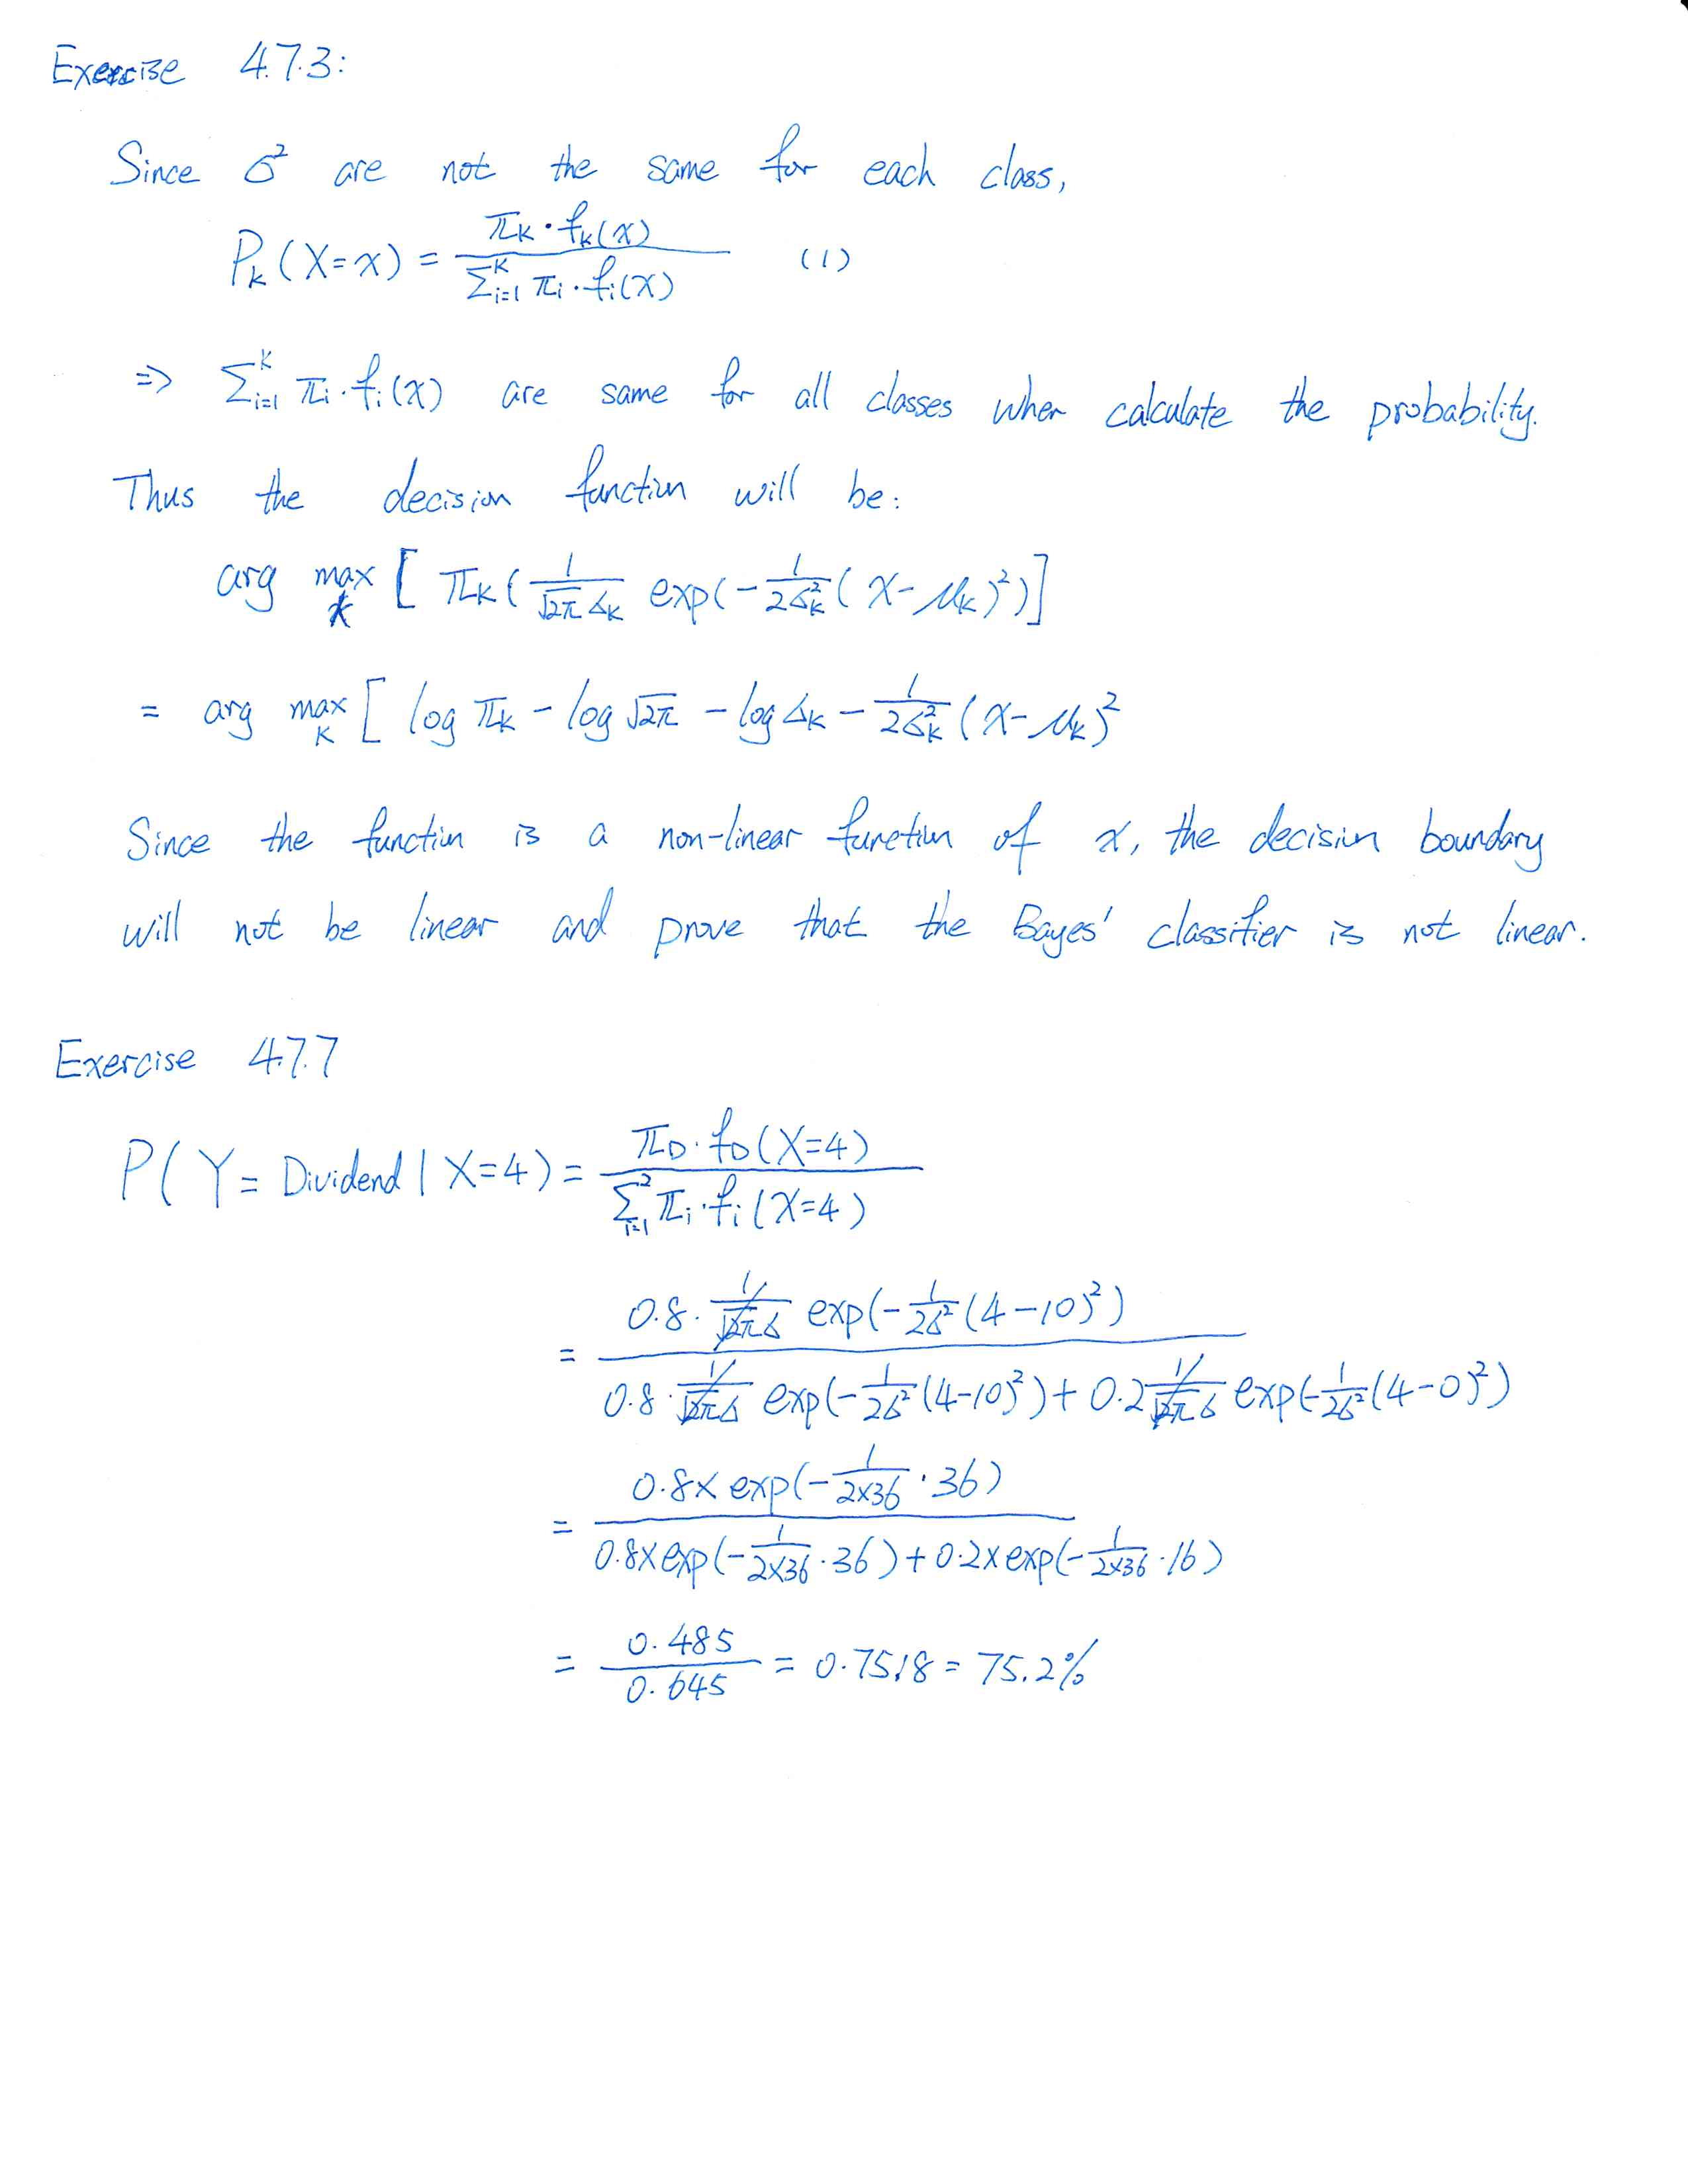


